# Pipeline for Analyzing Asters

Today we will extract ATP gradients from an aster dataset. Executing the next few cells will import all the relevant data.

## Imports

In [1]:
# # Packages to locally download data into the notebook:
# import requests
# import zipfile
import glob

#Numpy
import numpy as np

#For image plotting
import skimage.io

#Matplotlib plotting packages
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm

#Movie plotting


#For identifying aster center
from skimage.filters import threshold_otsu, gaussian
from skimage.measure import regionprops
import cv2

#for image registration
from skimage.registration import phase_cross_correlation
import os

# For loading bars
from tqdm.notebook import tqdm as tqdm
import aster_packages

from PIL import Image

## Importing plotting

In [2]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:

# Figure Formatting
import matplotlib.pyplot as plt
import matplotlib as mpl

figwidth = 8
plt.rcParams["figure.figsize"] = [figwidth, figwidth * 1105 / 1920
                                  ]  # figure size in inches
plt.rcParams["lines.linewidth"] = 2  # line width in points
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times"

plt.rcParams["font.style"] = "normal"
plt.rcParams["font.weight"] = "heavy"
plt.rcParams["font.size"] = 13.0
plt.rcParams["axes.labelweight"] = "bold"  # weight of the x and y labels
plt.rcParams["axes.spines.right"] = True
plt.rcParams[
    "axes.formatter.useoffset"] = True  # If True, the tick label formatter
plt.rcParams["xtick.major.size"] = 10  # major tick size in points
plt.rcParams["xtick.minor.size"] = 4  # minor tick size in points
plt.rcParams["xtick.direction"] = "in"  # direction in, out, or inout
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.major.size"] = 10  # major tick size in points
plt.rcParams["ytick.minor.size"] = 4  # minor tick size in points
plt.rcParams["ytick.direction"] = "in"  # direction in, out, or inout
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams["legend.fontsize"] = 10
plt.rcParams[
    "legend.labelspacing"] = 0.1  # the vertical space between the legend entries in fraction of fontsize
plt.rcParams["legend.shadow"] = False
plt.rcParams[
    "legend.frameon"] = True  # whether or not to draw a frame around legend
plt.rcParams[
    'axes.unicode_minus'] = False  # fix glyph error by using normal hyphens
mpl.rc("figure", dpi=200)

## Initializing Images

In [3]:
# Converts List of image file paths to array of Images
def file_to_image(files):
    """
    Takes in a file list and converts to images.
    
    Parameters:
    files: list of file names that you want to read into images
    
    Returns:
    An array of np.int16 images
    """
    im_list = list()
    for file in files:
        im = skimage.io.imread(file)
        im_list.append(im.astype(np.int16))

    return np.array(im_list)

### Specifying files

In [4]:
#Choose the experiment file name(located in folder 'Asters'):
file_path = '../../data/aster'
file_folder = '2022-07-06_square_k401_ATEAM_7'

# #Choose the position(s)/aster(s) of interest:
pos_list = ['Pos0']

#Choose the channels of interest (this is almost always going to be Cherry and iATP)
channel_list = ['GFP', 'CFP', 'MT']

#included frames
included_frames = '*2022*.tif'

### Creating image arrays

In [5]:
# Import images
for pos in pos_list:
    for channel in channel_list:

        #creates an empty list with the naming convention
        exec('im_files' + channel + pos + '= []')
        im_files = eval('im_files' + channel + pos)
        
        #appends all the file names
        im_files.append(
            np.sort(
                glob.glob(file_path + '/' + file_folder + '/' + pos + '/' + channel + '/' +
                          included_frames)))

        #Reads the files as images
        exec('im_array' + channel + pos + ' = file_to_image(im_files[0])')
        print('im_array' + channel + pos)

im_arrayGFPPos0
im_arrayCFPPos0
im_arrayMTPos0


In [6]:
print(len(im_arrayGFPPos0), len(im_arrayCFPPos0), len(im_arrayMTPos0))

200 200 400


### Reading bg images

In [7]:
#Choose the dark ims file name(located in folder 'Asters'):
file_path = '../../data/dark'

im_MT_dark = skimage.io.imread(
    file_path + '/' + '*C1*.ome.tif'
).astype(np.int16)

im_GFP_dark = skimage.io.imread(
    file_path + '/' + '*C2*.ome.tif'
).astype(np.int16)

im_CFP_dark = skimage.io.imread(
    file_path + '/' + '*C3*.ome.tif'
).astype(np.int16)

### Param calibration

In [8]:
#Length Calibration (microns to pixels)
um_per_pixel = 0.59

#Image dims
w_px, h_px = 1920, 1200  #pixels
w_um, h_um = w_px * um_per_pixel, h_px * um_per_pixel  # microns

#Fontsize
f_small, f_big = 13, 15

#Total number of imported images per channel
total_frames_MT = len(im_arrayMTPos0)
total_frames_GPF = len(im_arrayGFPPos0)
total_frames_CPF = len(im_arrayCFPPos0)

### Checking Arrays

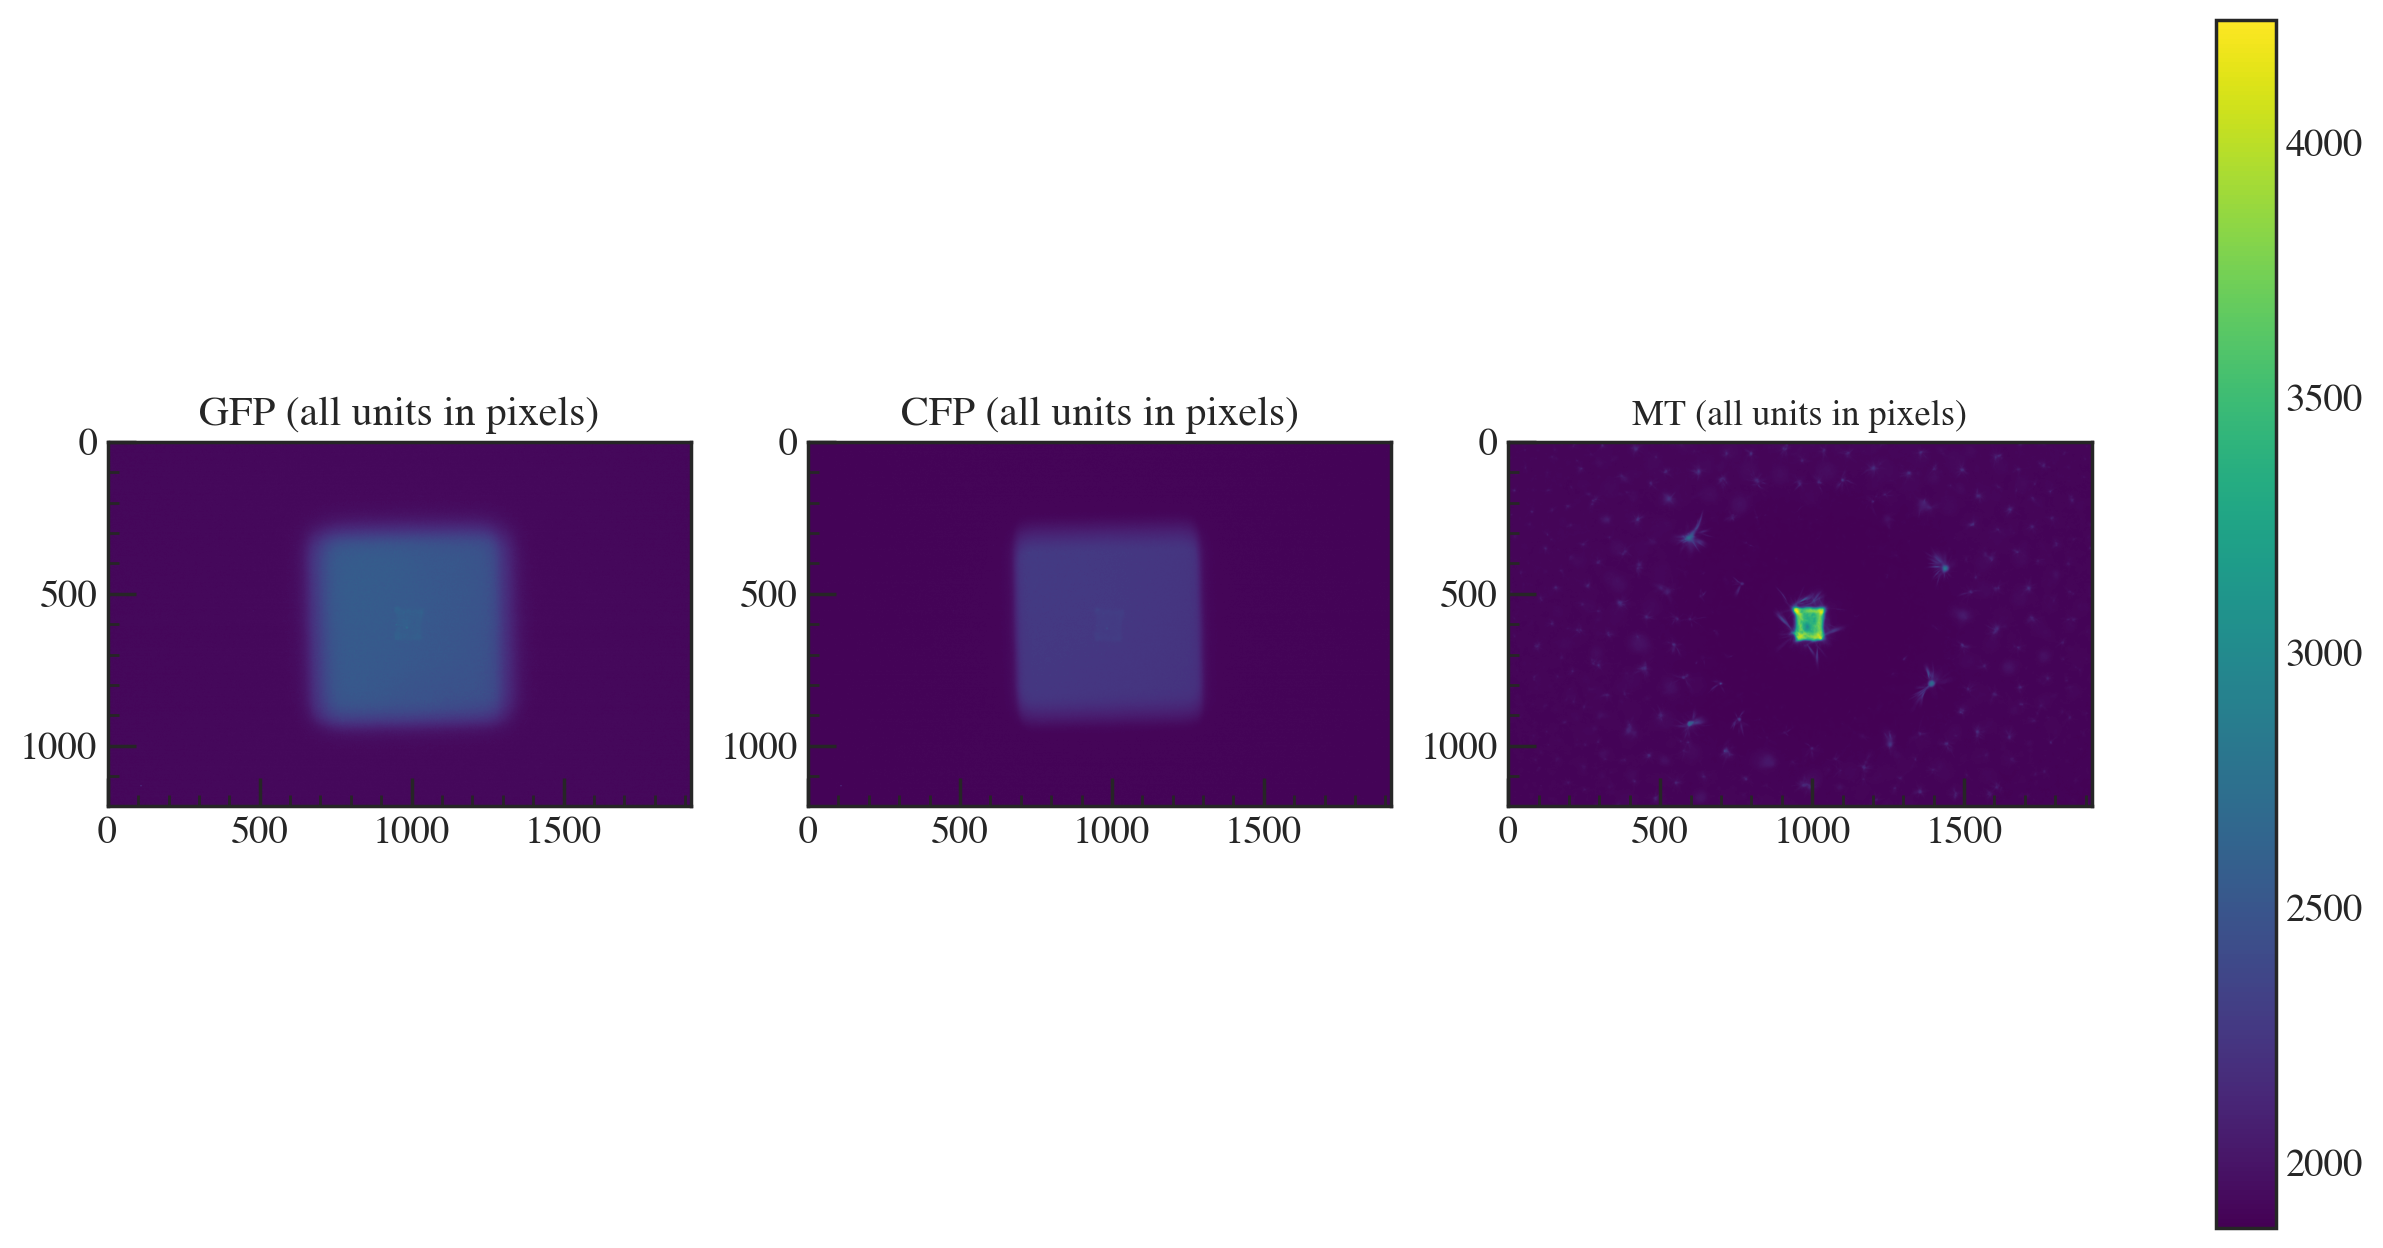

In [9]:
frame = 100
im_MT = im_arrayMTPos0[frame]
im_CFP = im_arrayCFPPos0[frame]
im_GFP = im_arrayGFPPos0[frame]

#define colorbar max and min
colorbar_max = np.percentile(im_GFP, 100)
colorbar_min = np.percentile(im_CFP, 0)

#define plot
fig, ax = plt.subplots(1, 3, figsize=(16, 8))
cmap = cm.get_cmap('viridis')
normalizer = Normalize(colorbar_min, colorbar_max)
cb_setting = cm.ScalarMappable(norm=normalizer)

#define each subplot

ax[0].imshow(im_GFP)
ax[0].set_title('GFP (all units in pixels)', fontsize=f_big)

ax[1].imshow(im_CFP)
ax[1].set_title('CFP (all units in pixels)', fontsize=f_big)

#subplots: setting bg plots
ax[2].imshow(im_MT)
ax[2].set_title('MT (all units in pixels)', fontsize=f_small)

fig.colorbar(cb_setting, ax=ax.ravel().tolist())

### Subtracting bg image and Normalising

In [10]:
# subtracting bg image from microtubule channel

im_arrayMTPos0_bs = im_arrayMTPos0 - im_MT_dark
im_arrayGFPPos0_bs = im_arrayGFPPos0 - im_GFP_dark
im_arrayCFPPos0_bs = im_arrayCFPPos0- im_CFP_dark

# Set negative values to zero
bool_array = (im_arrayGFPPos0_bs > 0)
im_arrayGFPPos0_bs = im_arrayGFPPos0_bs * bool_array

bool_array = (im_arrayCFPPos0_bs > 0)
im_arrayCFPPos0_bs = im_arrayCFPPos0_bs * bool_array

bool_array = (im_arrayMTPos0_bs > 0)
im_arrayMTPos0_bs = im_arrayMTPos0_bs * bool_array

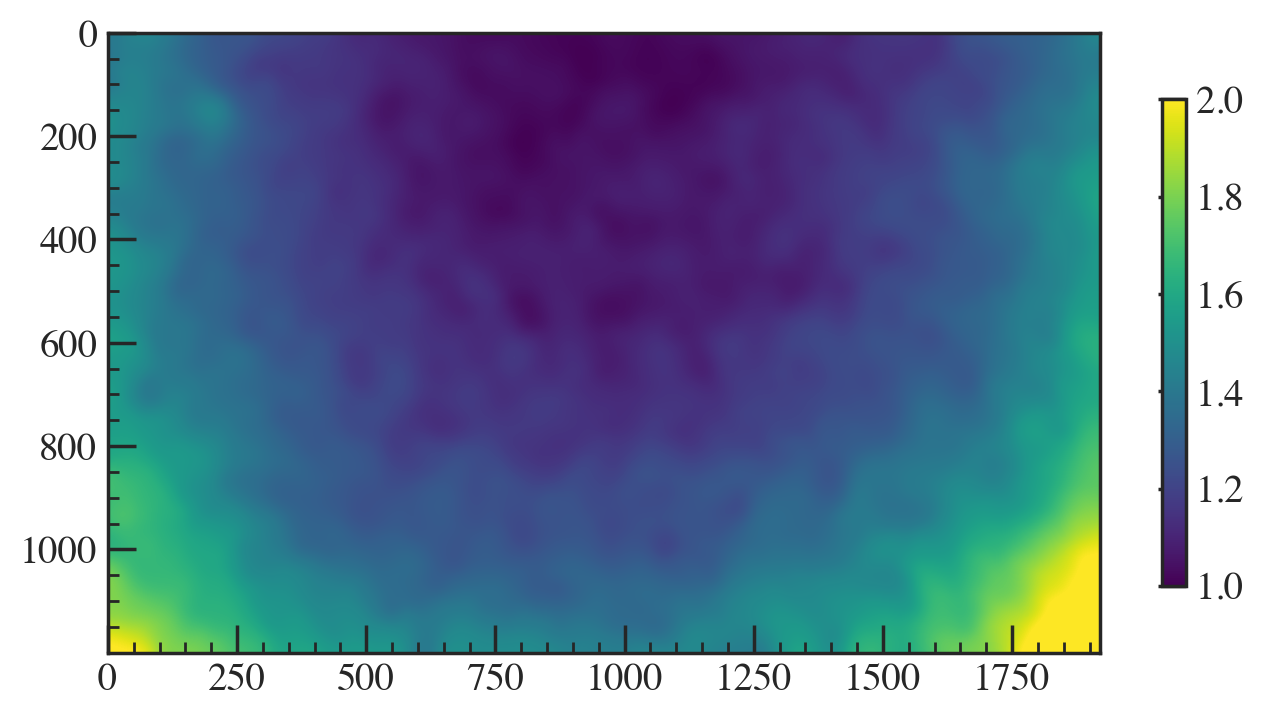

In [11]:
# subtracting bg image from GFP, CFP and Motor channel
# finding the normalisation matrix for the GFP, CFP and Motor Channel

GFP_zero = im_arrayGFPPos0[0]
CFP_zero = im_arrayCFPPos0[0]
MT_zero = im_arrayMTPos0[0]

GFP_norm_mat = aster_packages.norm_mat_fn_iATP(GFP_zero, im_GFP_dark)
CFP_norm_mat = aster_packages.norm_mat_fn_iATP(CFP_zero, im_CFP_dark)
MT_norm_mat = aster_packages.norm_mat_fn_iATP(MT_zero, im_MT_dark)

plt.imshow(MT_norm_mat, vmin = 1, vmax = 2)
plt.colorbar(shrink = 0.7)

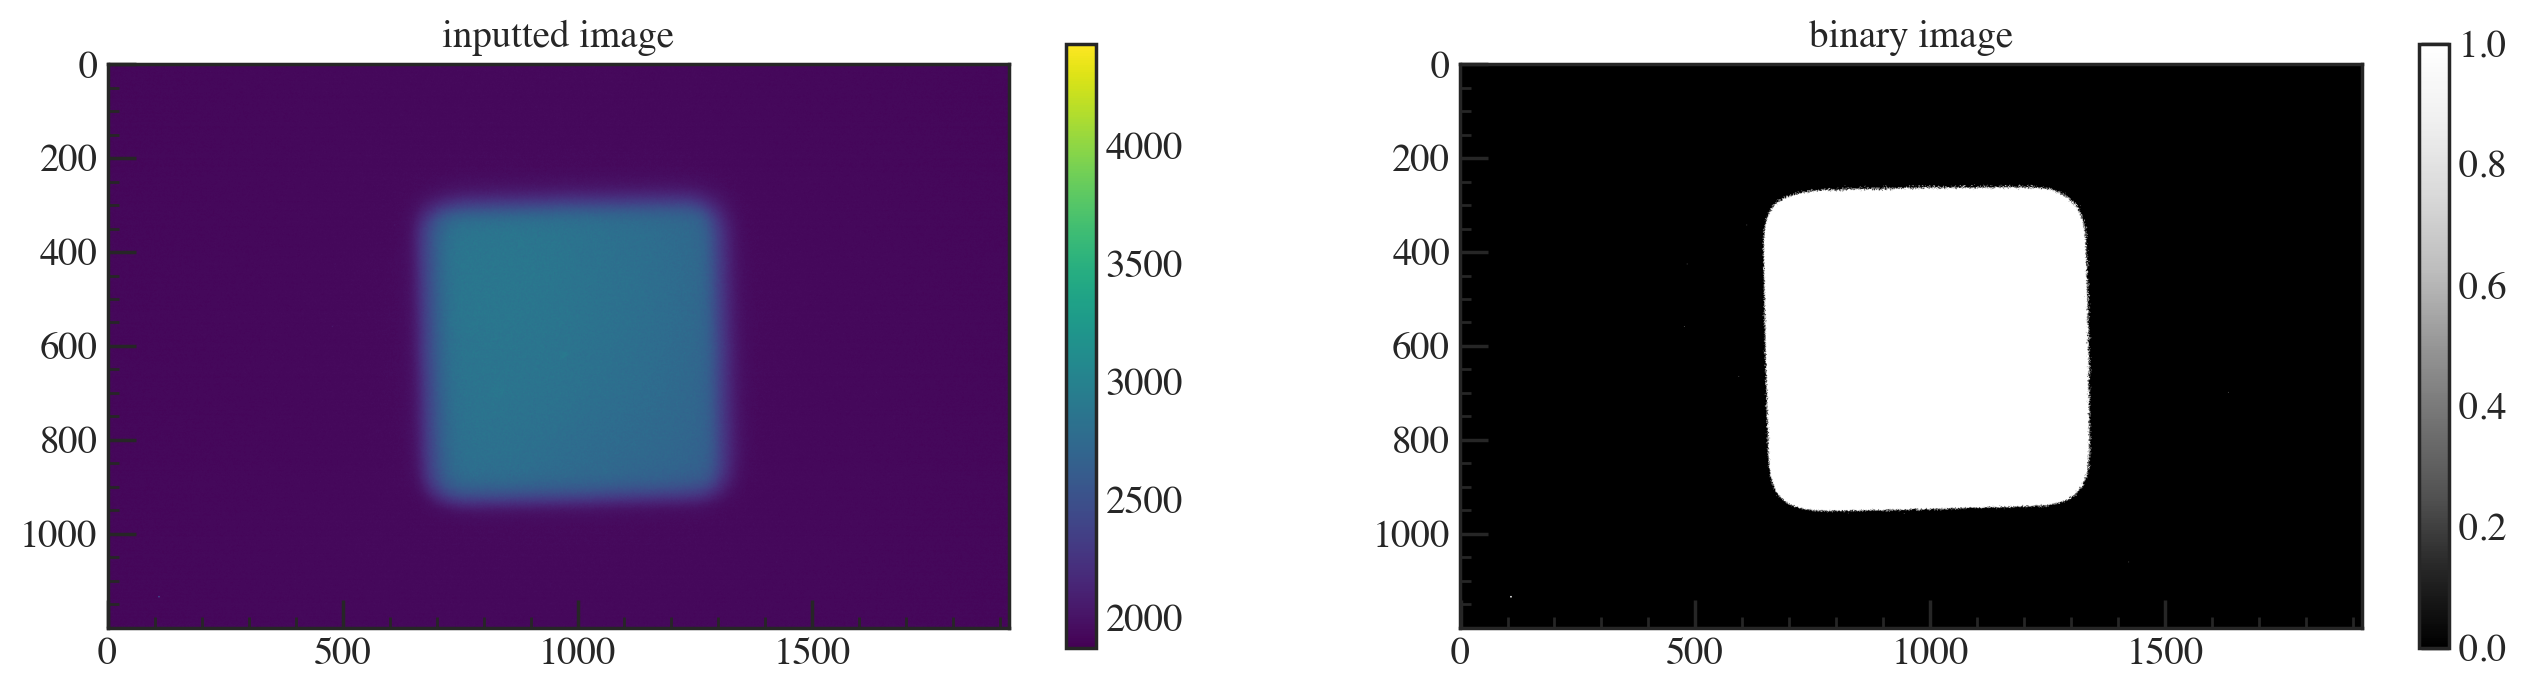

In [12]:
im_arrayGFPPos0 = im_arrayGFPPos0.astype(float)
im_arrayCFPPos0 = im_arrayCFPPos0.astype(float)
im_arrayMTPos0 = im_arrayMTPos0.astype(float)

im_binary = aster_packages.binary_im_generator(GFP_zero)
GFP_norm_mask = GFP_norm_mat * im_binary
CFP_norm_mask = CFP_norm_mat * im_binary

im_arrayGFPPos0_norm = GFP_norm_mask * im_arrayGFPPos0_bs
im_arrayCFPPos0_norm = CFP_norm_mask * im_arrayCFPPos0_bs
im_arrayMTPos0_norm = MT_norm_mat * im_arrayMTPos0_bs

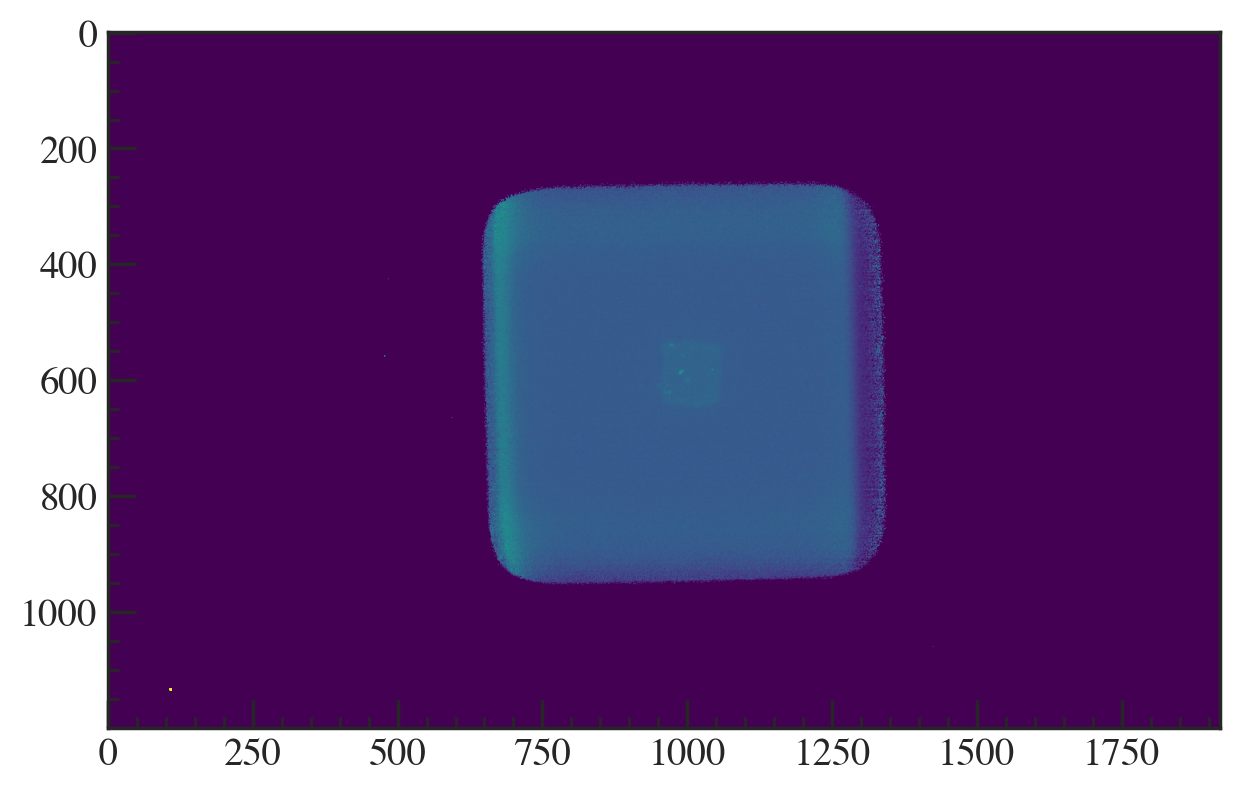

In [13]:
plt.imshow(im_arrayCFPPos0_norm[31], vmin=-0, vmax=2000)

### Defining Crops

In [15]:
#set crop pixel values
tc_r = 400
tc_ymin, tc_ymax, tc_xmin, tc_xmax = 600-tc_r, 600+tc_r, 960-tc_r, 960+tc_r #for 'tight crop'
#define crop window
tight_crop = np.s_[tc_ymin:tc_ymax, tc_xmin:tc_xmax]

#set crop pixel values
wc_ymin, wc_ymax, wc_xmin, wc_xmax = 515, 615, 900, 1010  #for 'tight crop'
#define crop window
wide_crop = np.s_[wc_ymin:wc_ymax, wc_xmin:wc_xmax]

c_ymin, c_ymax, c_xmin, c_xmax = 100, 900, 700, 1500
# define crop window
crop = np.s_[c_ymin:c_ymax, c_xmin:c_xmax]

Find the center for each image

### Finding Center of Square

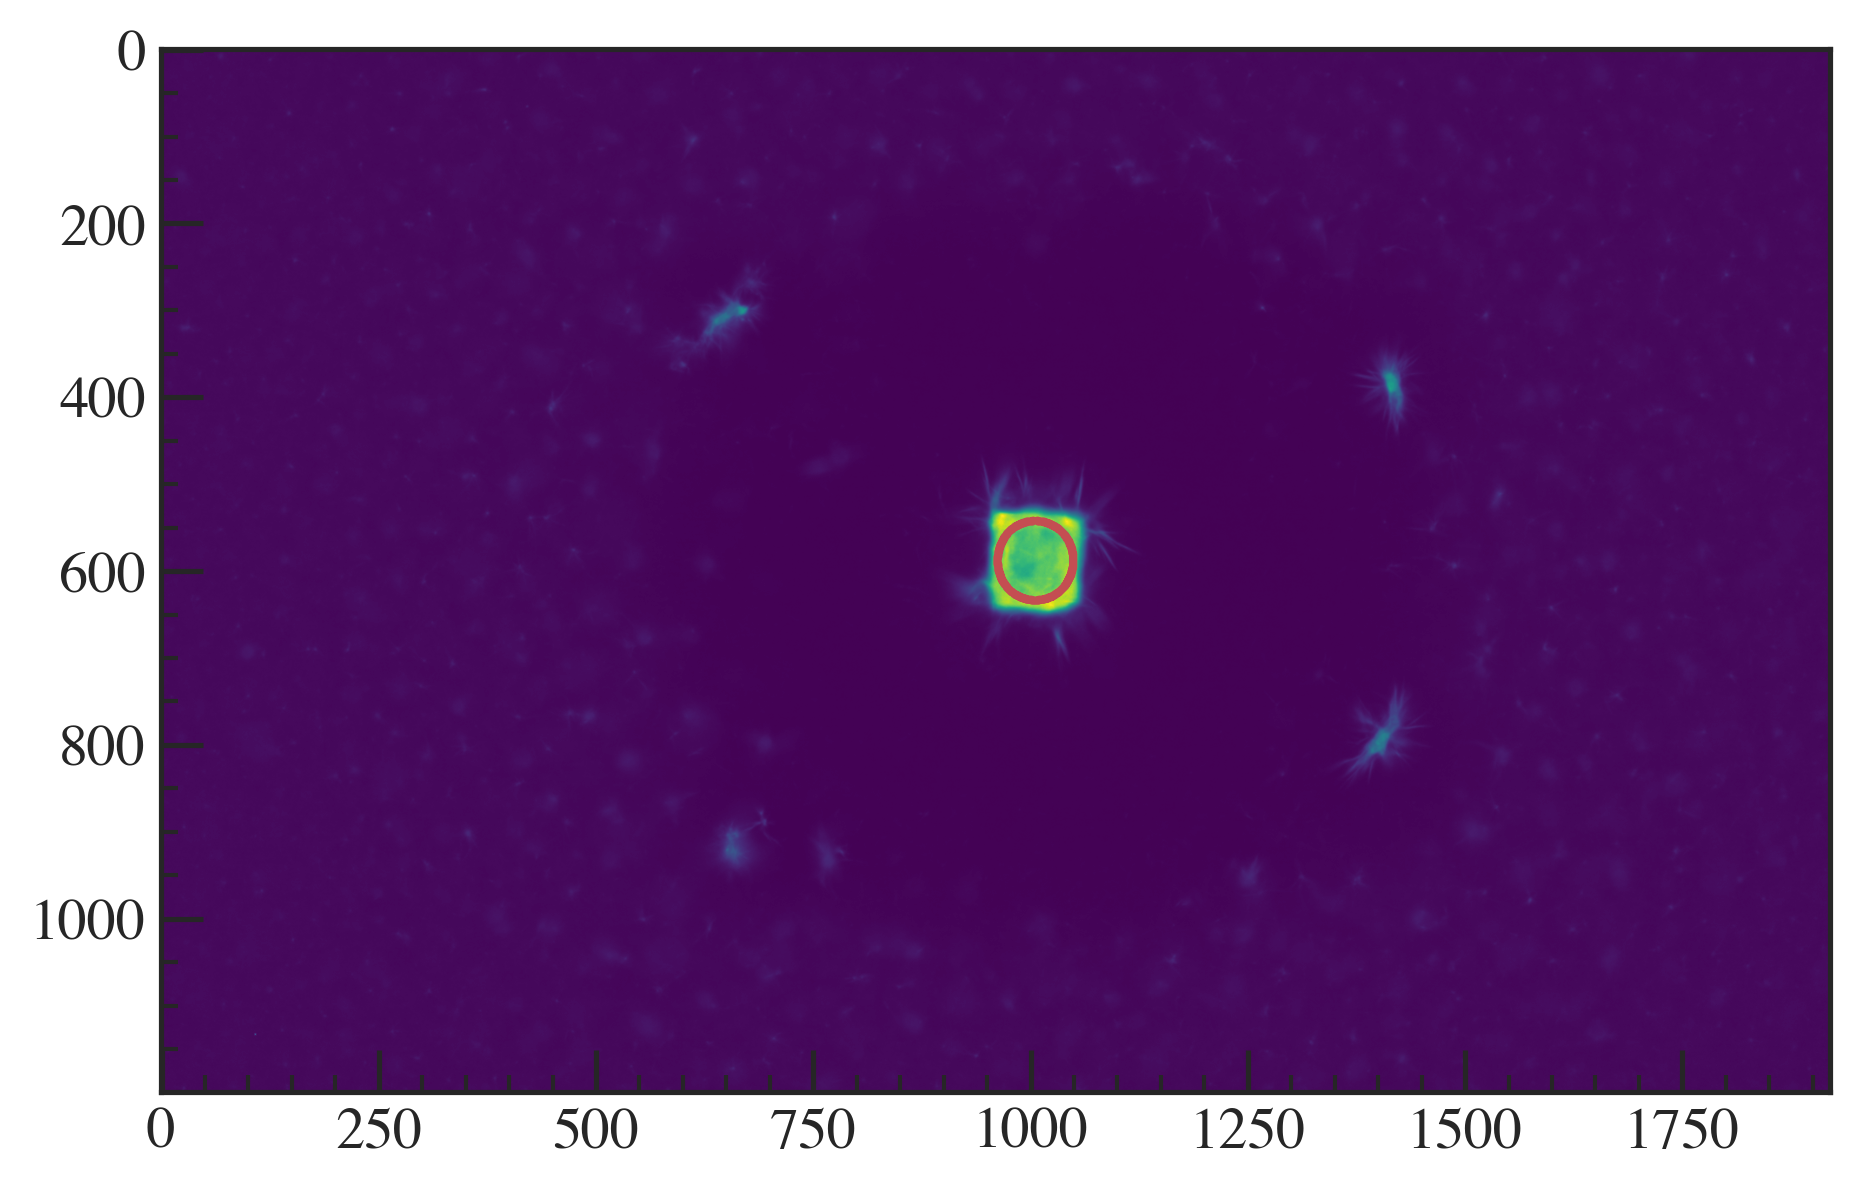

In [16]:
# testing for single image
im = im_arrayMTPos0_norm[60]

im_gaussian = gaussian(im[crop], sigma=50)
thresh = np.percentile(im_gaussian, 99)
binary = (im_gaussian>thresh).astype(np.uint8)

#create a contour
contours, hierarchy = cv2.findContours(binary, 1, 2)
contours = np.array(contours)
contours[:,:,0,0] += c_xmin
contours[:,:,0,1] += c_ymin
contours = np.squeeze(contours)

fig, ax = plt.subplots(dpi = 300)
ax.imshow(im)
ax.plot(contours[:,0],contours[:,1],'r-')


Find what the center vcalues are for full sized image

In [17]:
#init empty lists for center vals, radius, frame #

# min area thresh for contour (IN PIXELS)
area_thresh = 1000

centers_tc = []
radii = []
frame_num = []
contours_plot = []

#for loop thru MT images
for i, im in enumerate(im_arrayMTPos0_norm):
    #crop image for center identification
    print(i, end = '\r')
    #gaussian blur
    dst = gaussian(im[crop], sigma=50)
    thresh = threshold_otsu(dst)
    #thresh = np.percentile(dst, 99)

    binary = (dst>thresh).astype(np.uint8)
    
    #create a contour
    contours, hierarchy = cv2.findContours(binary, 1, 2)

    #iterate through contours (for most connected region)
    max_area = 0
    max_index = None

    for j, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            max_index = j

    if max_area >= area_thresh:
        cnt = contours[max_index]
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        centers_tc.append([x + c_xmin, y + c_ymin])
        radii.append(radius)
        frame_num.append(i)
        
        cnt = np.array(cnt)
        cnt = np.squeeze(cnt)
        cnt[:,0] += c_xmin
        cnt[:,1] += c_ymin
        contours_plot.append(cnt)
        
    else:
        print("**CENTER NOT FOUND**")
        cnt = contours[max_index]
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        centers_tc.append([x + c_xmin, y + c_ymin])
        radii.append(radius)        
        cnt = np.array(cnt)
        cnt = np.squeeze(cnt)
        cnt[:,0] += c_xmin
        cnt[:,1] += c_ymin
        contours_plot.append(cnt)
        
centers_tc = np.array(centers_tc)
radii = np.array(radii)
frame_num = np.array(frame_num)

In [18]:
centers = []
for center in centers_tc:
    center_x = int(center[0])
    center_y = int(center[1])
    centers.append([center_x, center_y])
centers = np.array(centers)
print(len(centers))

400


In [19]:
#fixing bright frames
centers[17,:]=centers[19,:]
centers[18,:]=centers[19,:]
centers[29,:]=centers[31,:]
centers[30,:]=centers[31,:]
centers[35,:]=centers[37,:]
centers[36,:]=centers[37,:]
centers[93,:]=centers[95,:]
centers[94,:]=centers[95,:]

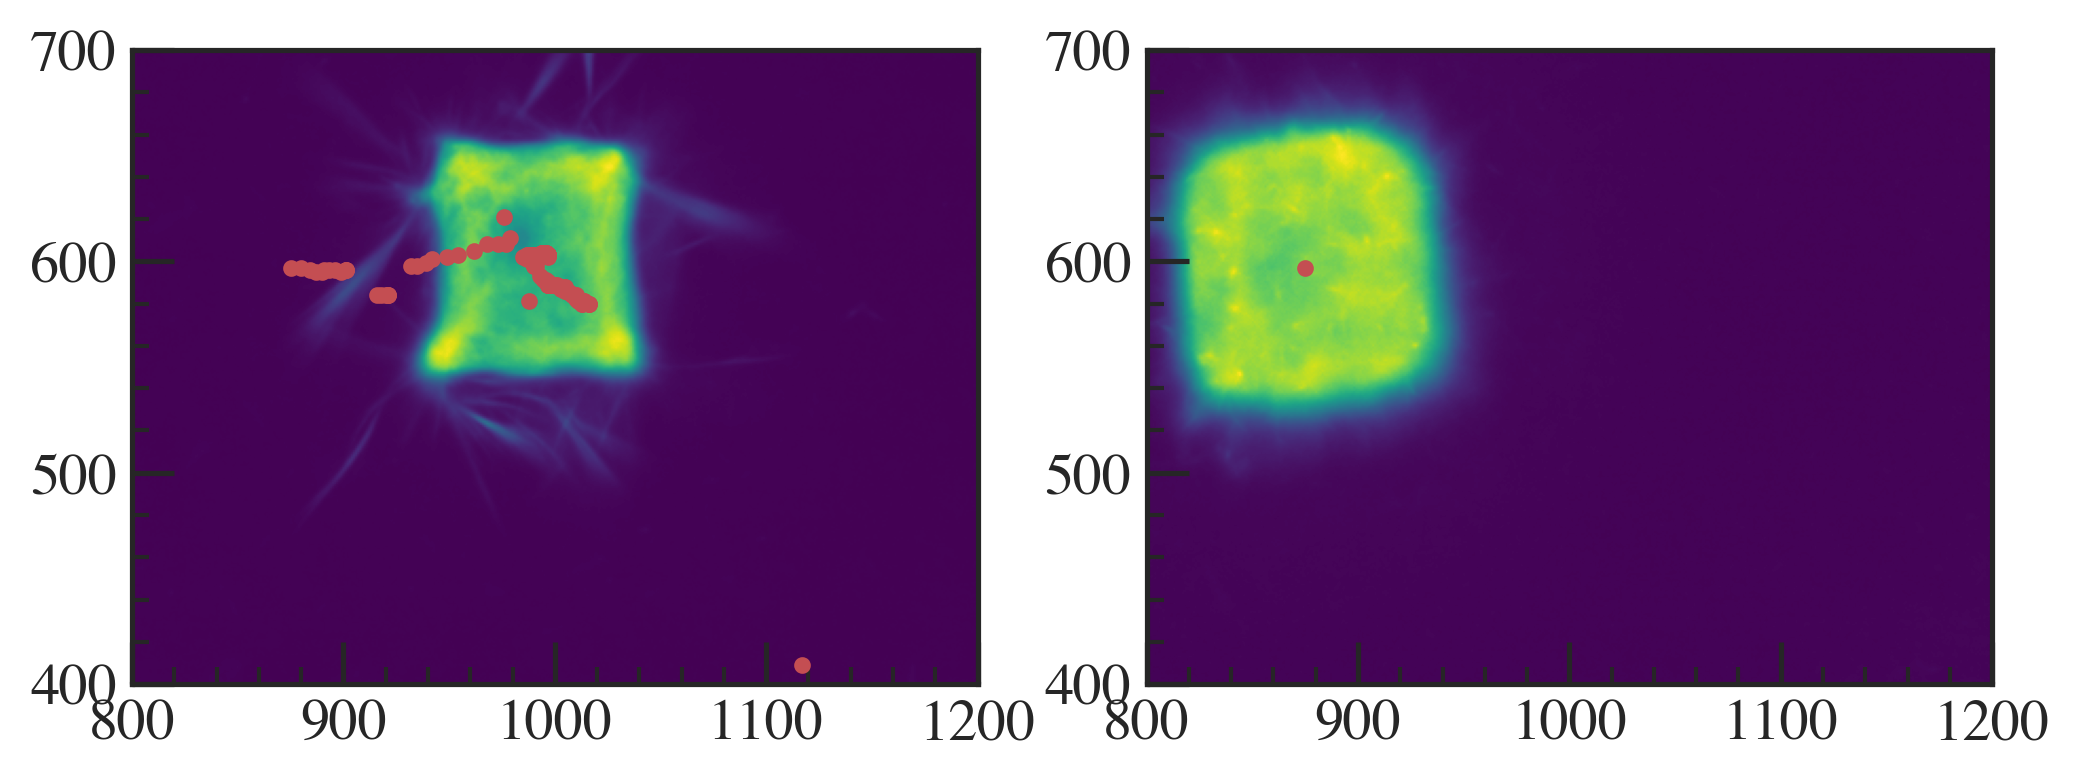

In [20]:
#TEST: plotting all centers
fig, axs = plt.subplots(1,2, dpi=300)

axs[0].plot(centers[:, 0], centers[:, 1], '.r')
axs[0].imshow(im_arrayMTPos0_norm[100])
axs[0].set(xlim = (800, 1200),ylim = (400, 700));

index = 28
axs[1].imshow(im_arrayMTPos0_norm[index])
axs[1].plot(centers[index,0], centers[index,1], '.r')
axs[1].set(xlim = (800, 1200),ylim = (400, 700));

In [21]:
#creating movie to check center detection
crops = []
length = 100
for i in range(len(im_arrayMTPos0_norm)):
    crops.append(np.s_[centers[i][1]-length:centers[i][1]+length, centers[i][0]-length:centers[i][0]+length])

im_arrayMTPos0_norm_cropped = [im_arrayMTPos0_norm[i][crops[i]] for i in range(len(im_arrayMTPos0_norm))]

im_arrayMTPos0_norm_cropped = [Image.fromarray(im) for im in im_arrayMTPos0_norm_cropped]

im_arrayMTPos0_norm_cropped[0].save("test.tif", save_all=True, append_images=im_arrayMTPos0_norm_cropped[1:])

## Register

Register images

In [22]:
centers

array([[1319,  724],
       [1322,  807],
       [1406,  166],
       [1117,  409],
       [ 988,  581],
       [ 976,  621],
       [ 979,  611],
       [ 977,  608],
       [ 973,  608],
       [ 968,  608],
       [ 962,  605],
       [ 954,  603],
       [ 949,  602],
       [ 942,  601],
       [ 939,  599],
       [ 935,  598],
       [ 932,  598],
       [ 901,  596],
       [ 901,  596],
       [ 901,  596],
       [ 899,  595],
       [ 896,  596],
       [ 893,  596],
       [ 891,  596],
       [ 890,  595],
       [ 887,  595],
       [ 884,  596],
       [ 880,  597],
       [ 875,  597],
       [ 921,  584],
       [ 921,  584],
       [ 921,  584],
       [ 920,  584],
       [ 918,  584],
       [ 916,  584],
       [1016,  580],
       [1016,  580],
       [1016,  580],
       [1014,  581],
       [1013,  581],
       [1014,  581],
       [1013,  581],
       [1013,  580],
       [1012,  581],
       [1013,  580],
       [1012,  581],
       [1011,  581],
       [1011,

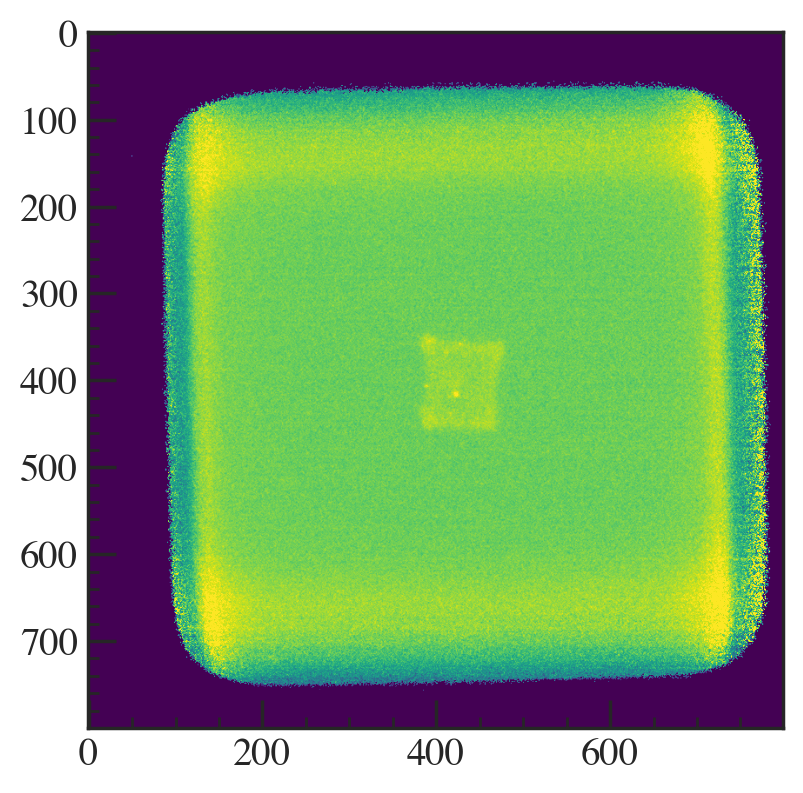

In [23]:
plt.imshow(im_arrayCFPPos0_norm[100][tight_crop], vmin = 0, vmax = 1000)

In [24]:
#Empty list to record how much CFP (probe) channel is shifted w.r.t. GFP (ATP is bound) channel
shifts = []
total_frames = 144

for i in range(len(im_arrayCFPPos0_norm)):
    print(i, end = '\r')
    shift, error, _ = phase_cross_correlation(
        im_arrayGFPPos0_norm[i][tight_crop], im_arrayCFPPos0_norm[i][tight_crop])
    shifts.append(shift)

shifts = np.array(shifts)
len(im_arrayCFPPos0_norm)

200

In [25]:
print(len(shifts))
shifts

200


array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.

## Getting ATP Data

In [26]:
#cropped aster images
winsize = 200
thickness = 20

im_arrayGFPPos0_plot = []
im_arrayCFPPos0_plot = []
im_arrayMTPos0_plot = []

ratios_plot = []

#Traces for asters
GFP_trace_pts = []
CFP_trace_pts = []
MT_trace_pts = []
ratios_trace_pts = []

for i in range(len(im_arrayGFPPos0_norm)):

    #Set the window parameters
    i_min = int(centers[2*i][0] - winsize)
    i_max = int(centers[2*i][0] + winsize)
    j_min = int(centers[2*i][1] - winsize)
    j_max = int(centers[2*i][1] + winsize)

    #demi-variable for shift
    shift_j = int(shifts[i][0])
    shift_i = int(shifts[i][1])

    #set GFP and CFP windows
    winGFP = np.s_[j_min:j_max, i_min:i_max]
    winCFP = np.s_[(j_min - shift_j):(j_max - shift_j),
                   (i_min - shift_i):(i_max - shift_i)]
    winCherry = np.s_[j_min:j_max, i_min:i_max]

    #Append the plotting images
    im_arrayGFPPos0_plot.append(im_arrayGFPPos0_norm[i][winGFP])
    im_arrayCFPPos0_plot.append(im_arrayCFPPos0_norm[i][winCFP])
    im_arrayMTPos0_plot.append(im_arrayMTPos0_norm[i][winCFP])
    #for now MT same as CFP shifts, running the shift cell seems closest to CFP
    
    try:
        ratio = im_arrayGFPPos0_norm[i][winGFP] / im_arrayCFPPos0_norm[i][winCFP]
        ratios_plot.append(ratio)
    except ValueError:
        ratios_plot.append(np.zeros((winsize,winsize)))

im_arrayGFPPos0_plot = np.array(im_arrayGFPPos0_plot)
im_arrayCFPPos0_plot = np.array(im_arrayCFPPos0_plot)
im_arrayMTPos0_plot = np.array(im_arrayMTPos0_plot)
ratios_plot = np.array(ratios_plot)

/var/folders/l0/nv_s611d4rjbvd6bfn24wlq80000gn/T/ipykernel_1019/1190119017.py:42: RuntimeWarning: divide by zero encountered in true_divide
  ratio = im_arrayGFPPos0_norm[i][winGFP] / im_arrayCFPPos0_norm[i][winCFP]
/var/folders/l0/nv_s611d4rjbvd6bfn24wlq80000gn/T/ipykernel_1019/1190119017.py:42: RuntimeWarning: invalid value encountered in true_divide
  ratio = im_arrayGFPPos0_norm[i][winGFP] / im_arrayCFPPos0_norm[i][winCFP]
/var/folders/l0/nv_s611d4rjbvd6bfn24wlq80000gn/T/ipykernel_1019/1190119017.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  im_arrayGFPPos0_plot = np.array(im_arrayGFPPos0_plot)
/var/folders/l0/nv_s611d4rjbvd6bfn24wlq80000gn/T/ipykernel_1019/1190119017.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which 

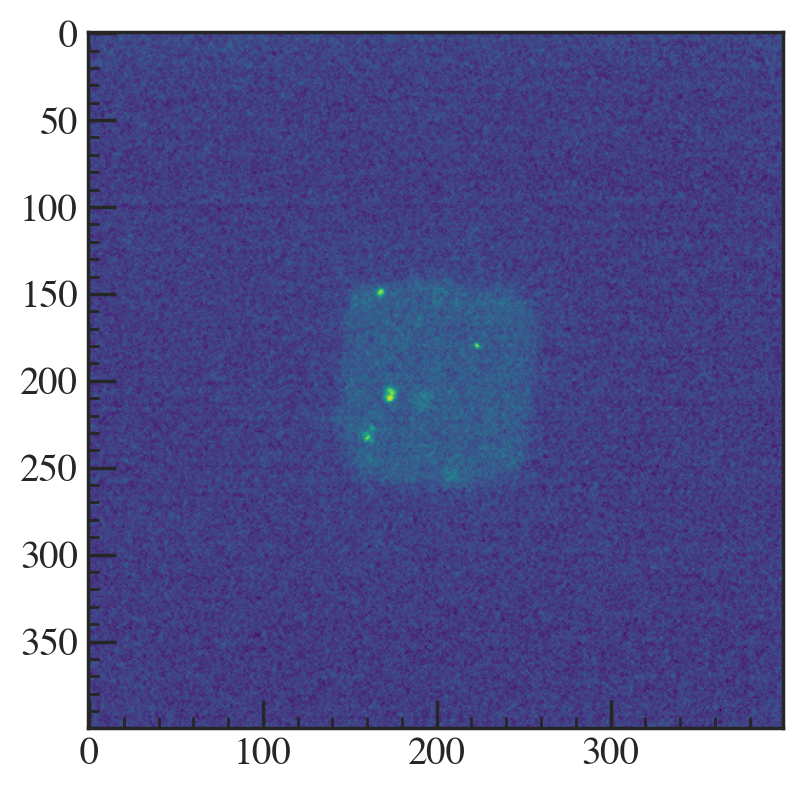

In [27]:
plt.imshow(im_arrayCFPPos0_plot[20])

### Plotting analysis

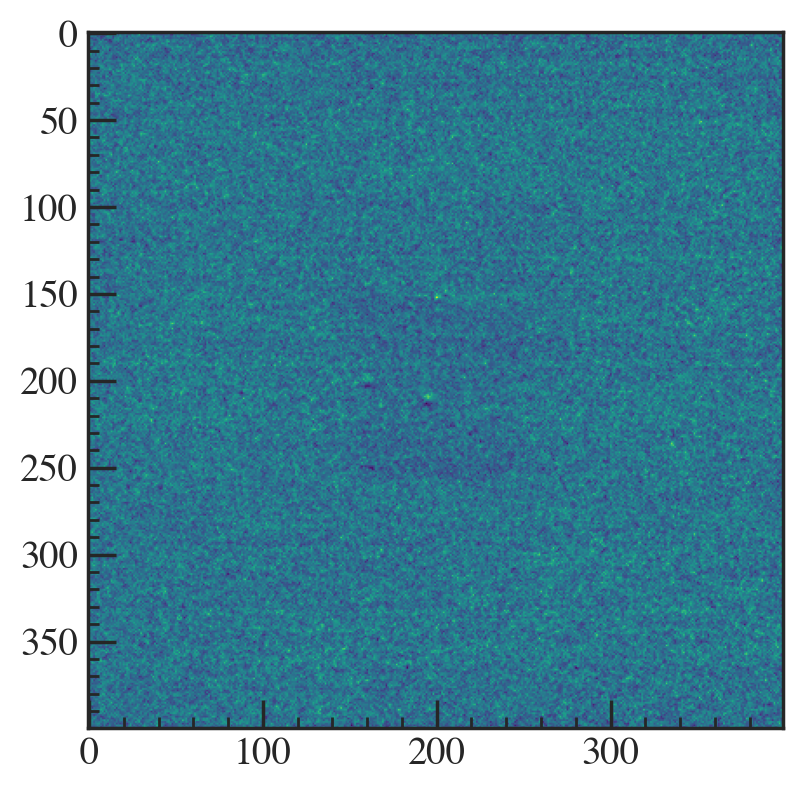

In [28]:
plt.imshow(ratios_plot[199])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


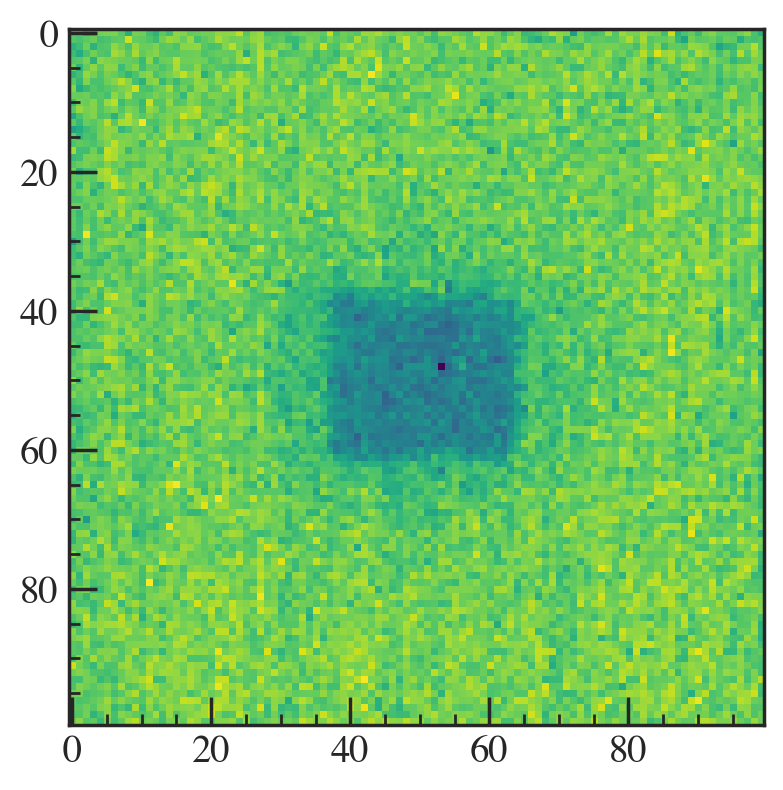

In [29]:
n_grids = 100
vals = np.zeros((n_grids,n_grids,len(ratios_plot)))
step = int(winsize*2/n_grids)
for k in range(len(ratios_plot)):
    for i in range(n_grids):
        for j in range(n_grids):
            vals[i,j,k] = np.average(ratios_plot[k][j*step:(j+1)*step,i*step:(i+1)*step])
            
plt.imshow(vals[:,:,47])

/var/folders/l0/nv_s611d4rjbvd6bfn24wlq80000gn/T/ipykernel_1019/2932474177.py:4: RuntimeWarning: invalid value encountered in sqrt
  return a*((c-ratio)/(ratio-b))**(1/d)


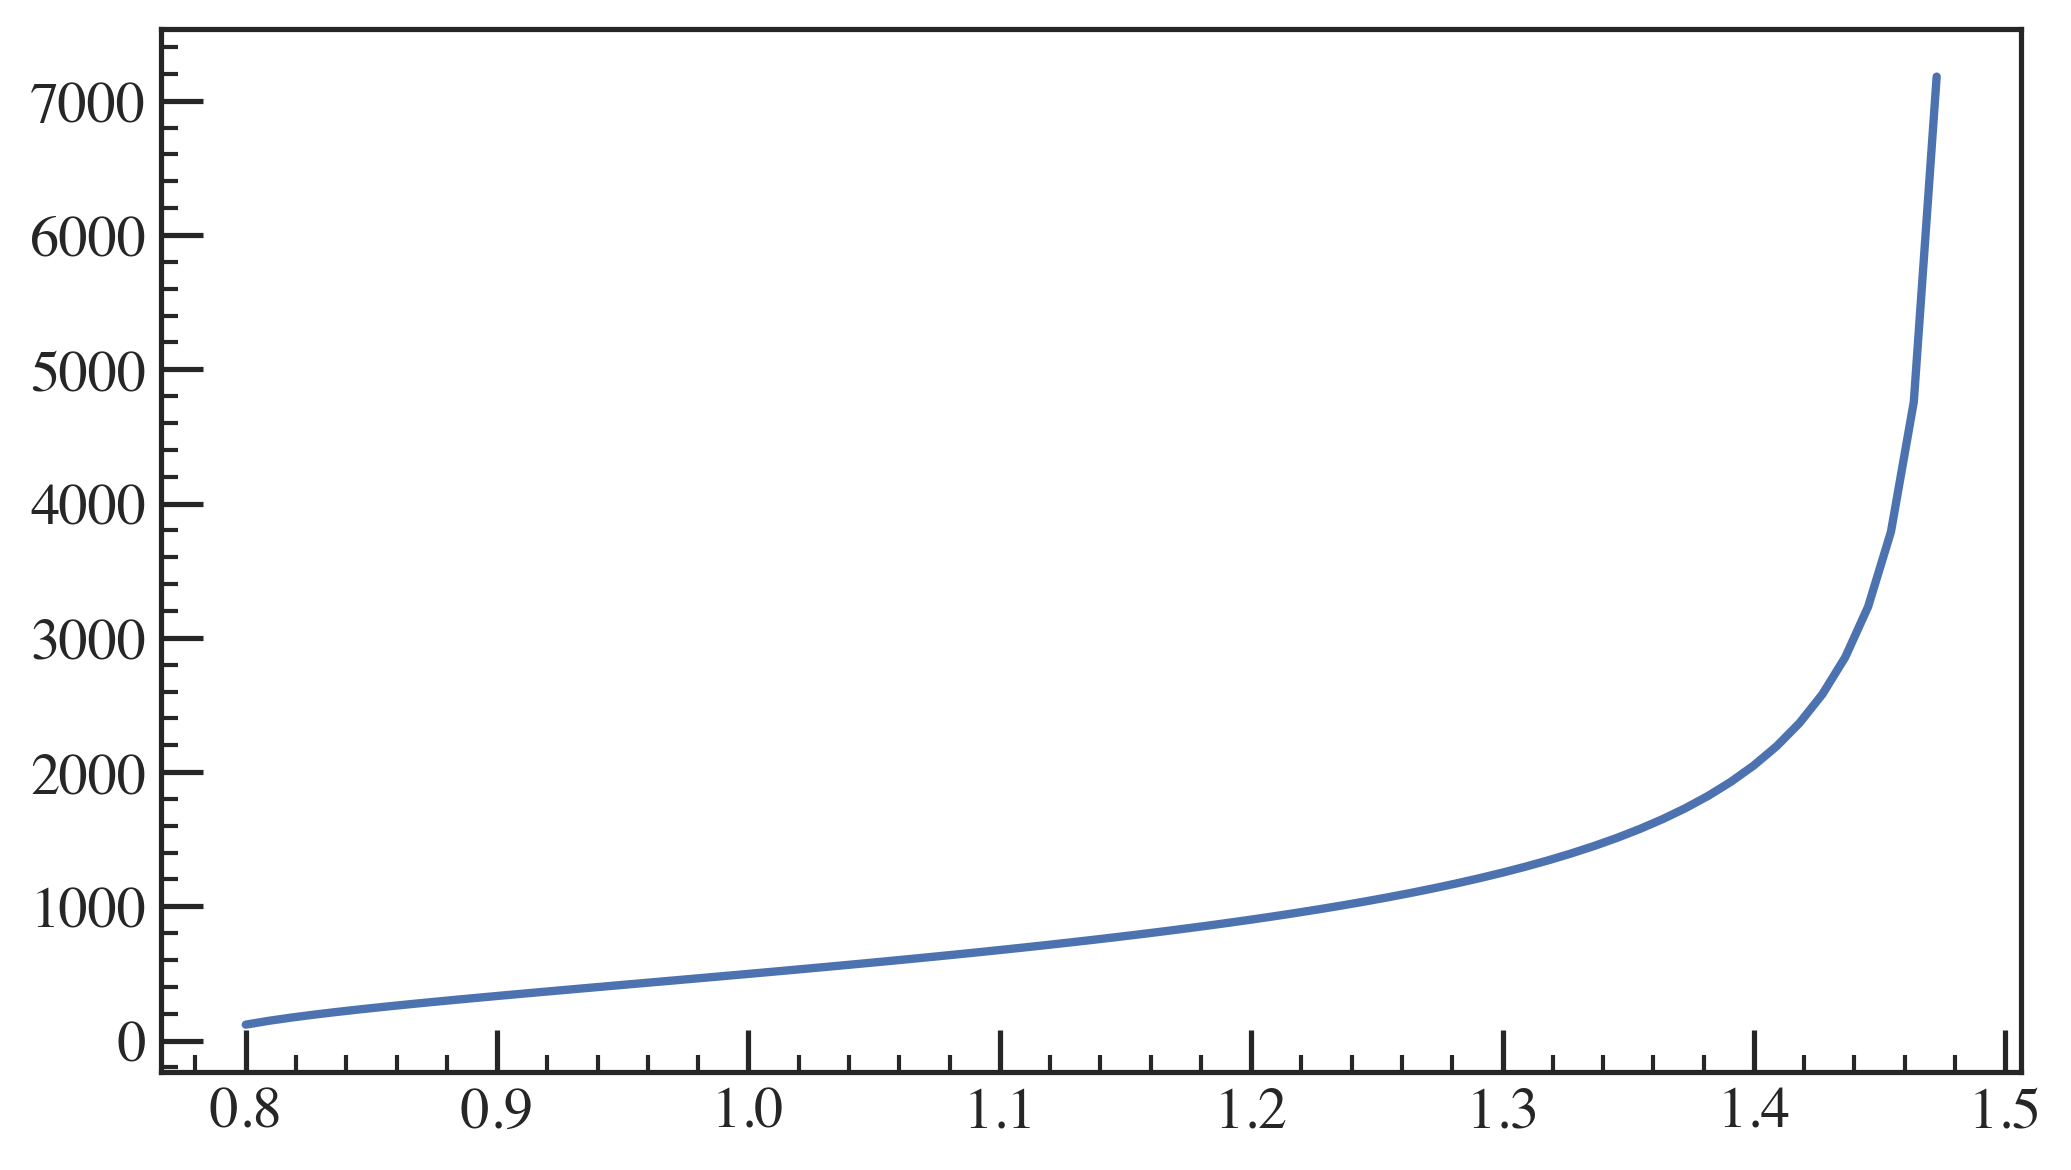

In [30]:
concentration_params = [737.79022346,1.4800163,0.78242639]

def concentration_function(ratio, a,b,c,d=2):
    return a*((c-ratio)/(ratio-b))**(1/d)

fig, ax = plt.subplots(dpi = 300)
xs = np.linspace(0.8,1.7,100)
ax.plot(xs,concentration_function(xs,*concentration_params))

/var/folders/l0/nv_s611d4rjbvd6bfn24wlq80000gn/T/ipykernel_1019/2932474177.py:4: RuntimeWarning: invalid value encountered in true_divide
  return a*((c-ratio)/(ratio-b))**(1/d)
/var/folders/l0/nv_s611d4rjbvd6bfn24wlq80000gn/T/ipykernel_1019/2932474177.py:4: RuntimeWarning: invalid value encountered in sqrt
  return a*((c-ratio)/(ratio-b))**(1/d)
/var/folders/l0/nv_s611d4rjbvd6bfn24wlq80000gn/T/ipykernel_1019/2932474177.py:4: RuntimeWarning: invalid value encountered in true_divide
  return a*((c-ratio)/(ratio-b))**(1/d)
/var/folders/l0/nv_s611d4rjbvd6bfn24wlq80000gn/T/ipykernel_1019/2932474177.py:4: RuntimeWarning: invalid value encountered in sqrt
  return a*((c-ratio)/(ratio-b))**(1/d)


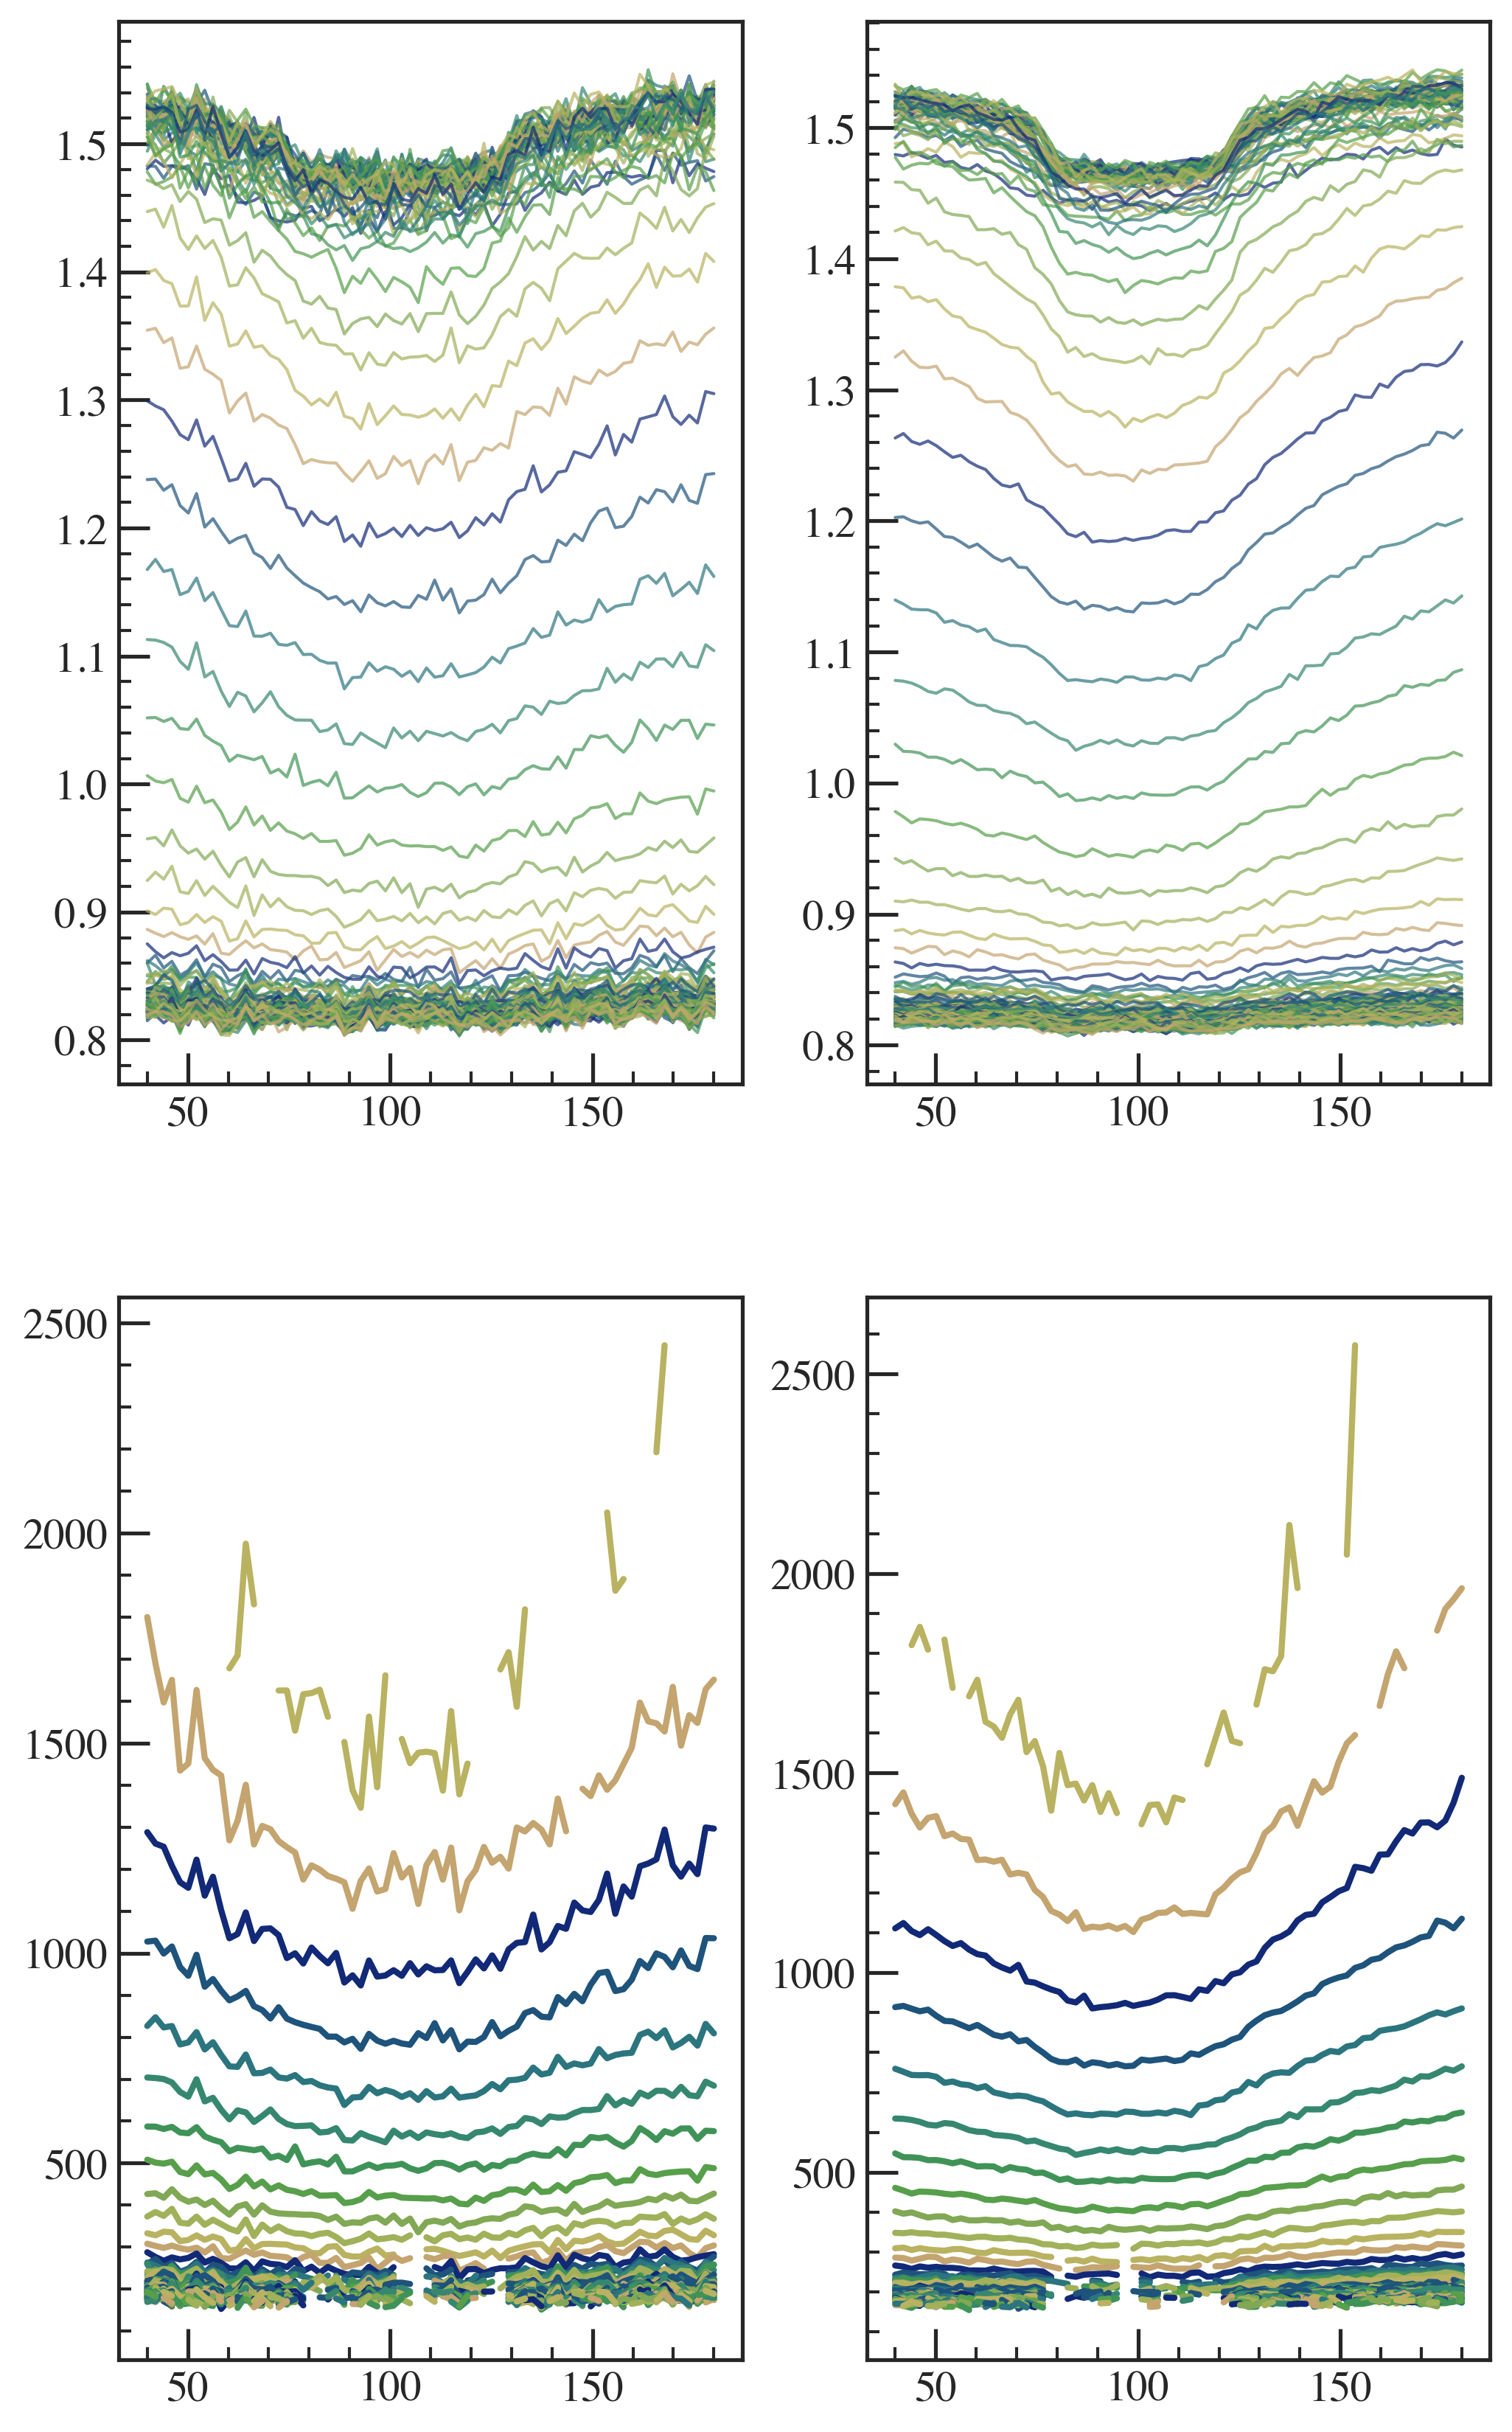

In [82]:
fig, axs = plt.subplots(2,2,dpi = 300, figsize = (8,14))

axs[0,0].set_prop_cycle(plt.cycler('color',plt.cm.gist_earth(np.linspace(0.1, 0.80, 10))))
axs[1,0].set_prop_cycle(plt.cycler('color',plt.cm.gist_earth(np.linspace(0.1, 0.80, 10))))
axs[0,1].set_prop_cycle(plt.cycler('color',plt.cm.gist_earth(np.linspace(0.1, 0.80, 10))))
axs[1,1].set_prop_cycle(plt.cycler('color',plt.cm.gist_earth(np.linspace(0.1, 0.80, 10))))

x_vals = np.transpose(np.array([np.linspace(len(ratios_plot)*20/100,len(ratios_plot)*(1-10/100),90-20) for x in range(190)]))

axs[0,0].plot(x_vals,np.average(vals, axis = 0)[20:90,10:], '-', lw =1, alpha = 0.7);
axs[0,1].plot(x_vals,np.average(vals, axis = 1)[20:90,10:], '-', lw =1, alpha = 0.7);
            

axs[1,0].plot(x_vals,np.average(concentration_function(vals,*concentration_params), axis = 0)[20:90,10:],'-');
axs[1,1].plot(x_vals,np.average(concentration_function(vals,*concentration_params), axis = 1)[20:90,10:],'-');

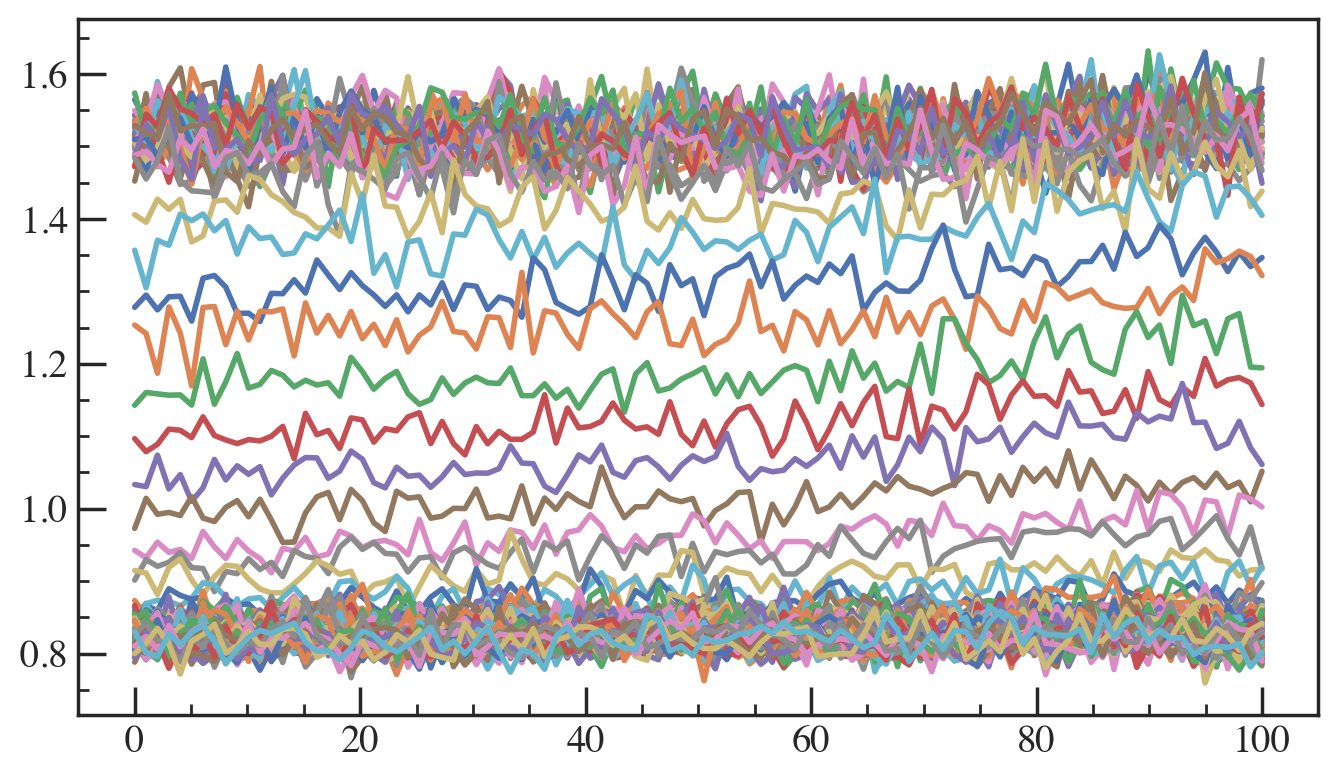

In [32]:
plt.plot(np.linspace(0,100,n_grids), vals[:,10,30:]);